In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim

In [11]:
pyLDAvis.enable_notebook()

In [2]:
train_orig = pd.read_csv("/home/sroberts/train.csv", engine='python')

In [4]:
test_orig = pd.read_csv("/home/sroberts/test.csv", engine='python')

## Target toxicity - imbalance

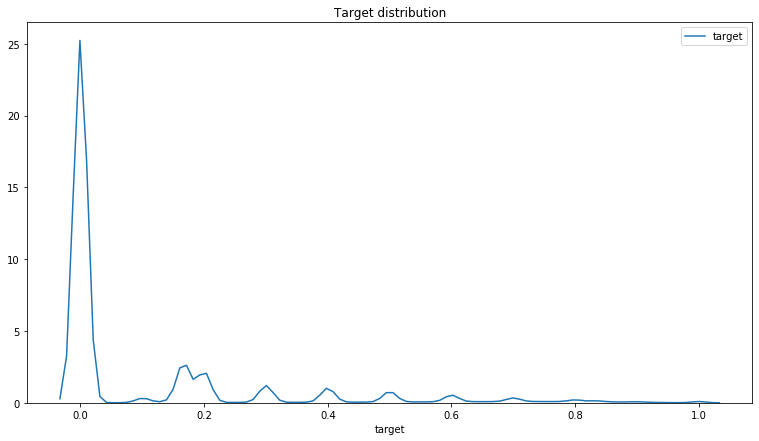

In [78]:
plt.figure(figsize=(13,7))
plt.title("Target distribution")
sns.distplot(train_orig['target'],kde=True,hist=False, bins=120, label='target')
plt.legend() 
plt.show()

### Convert all target - toxicity >= .5 as toxic, else non-toxic

In [19]:
train_orig.loc[train_orig.target >= 0.5, "toxic"] = 'toxic'
train_orig.toxic.fillna('non-toxic',inplace=True)

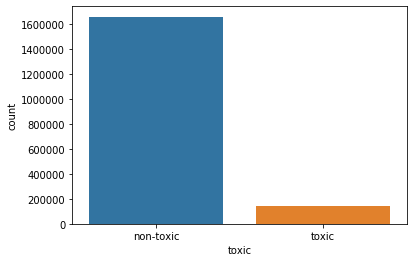

In [21]:
sns.countplot(x='toxic', data=train_orig)

## Wordclouds

In [70]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

#### Take samples from subsets of data and make word cloud

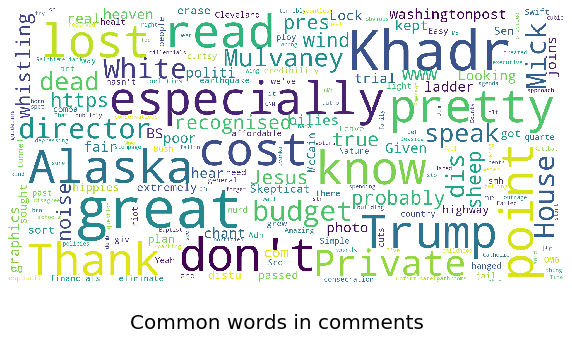

In [71]:
show_wordcloud(train_orig['comment_text'].sample(20000), title = 'Common words in comments')

In [72]:
tox = train_orig.comment_text[train_orig.toxic=='toxic']
nontox = train_orig.comment_text[train_orig.toxic=='non-toxic']

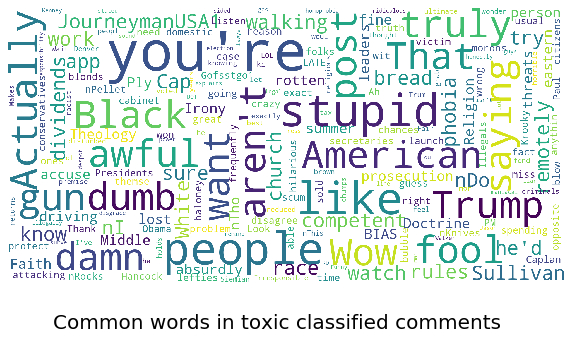

In [73]:
show_wordcloud(tox.sample(20000), title = 'Common words in toxic classified comments')

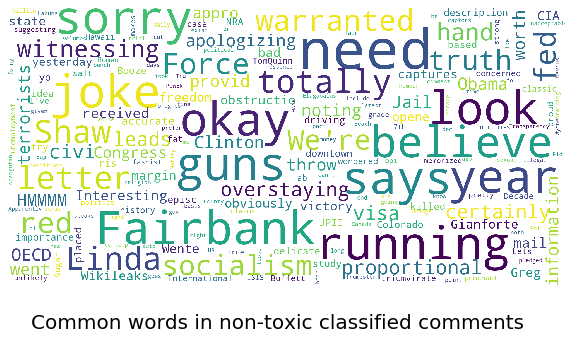

In [74]:
show_wordcloud(nontox.sample(20000), title = 'Common words in non-toxic classified comments')

In [75]:
most_tox = train_orig.comment_text[train_orig.target>.90]

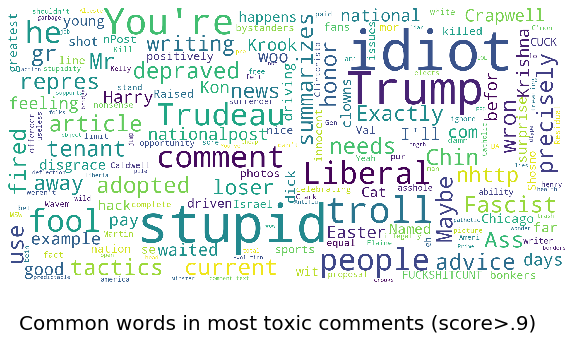

In [76]:
show_wordcloud(most_tox.sample(200), title = 'Common words in most toxic comments (score>.9)')

## LDA topic modeling

In [59]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result

In [60]:
%%time
preprocessed_comments = train_orig['comment_text'].sample(300000).map(preprocess)
dictionary = gensim.corpora.Dictionary(preprocessed_comments)
dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=75000)

CPU times: user 43.2 s, sys: 86.5 ms, total: 43.3 s
Wall time: 43.3 s


In [61]:
%%time
bow_corpus = [dictionary.doc2bow(doc) for doc in preprocessed_comments]
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

CPU times: user 9.53 s, sys: 52 ms, total: 9.58 s
Wall time: 9.57 s


In [69]:
%%time
lda_model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=20,id2word=dictionary, passes=2, workers=2)

CPU times: user 2min 52s, sys: 2.11 s, total: 2min 54s
Wall time: 2min 52s


In [63]:
topics = lda_model.print_topics(num_words=5)
for i, topic in enumerate(topics[:10]):
    print("Train topic {}: {}".format(i, topic))

Train topic 0: (0, '0.006*"maga" + 0.005*"blah" + 0.005*"medicare" + 0.004*"doctor" + 0.003*"test"')
Train topic 1: (1, '0.006*"climate" + 0.005*"change" + 0.004*"life" + 0.004*"jesus" + 0.004*"science"')
Train topic 2: (2, '0.011*"news" + 0.010*"fake" + 0.007*"trump" + 0.006*"troll" + 0.006*"putin"')
Train topic 3: (3, '0.012*"like" + 0.011*"idiot" + 0.007*"sounds" + 0.005*"dumb" + 0.005*"gonna"')
Train topic 4: (4, '0.005*"police" + 0.005*"crime" + 0.004*"true" + 0.004*"criminal" + 0.004*"sexual"')
Train topic 5: (5, '0.007*"game" + 0.007*"team" + 0.004*"year" + 0.004*"season" + 0.004*"play"')
Train topic 6: (6, '0.009*"white" + 0.006*"people" + 0.006*"black" + 0.005*"racist" + 0.005*"muslim"')
Train topic 7: (7, '0.011*"good" + 0.011*"thanks" + 0.009*"comment" + 0.009*"thank" + 0.007*"agree"')
Train topic 8: (8, '0.016*"trump" + 0.011*"vote" + 0.009*"party" + 0.009*"president" + 0.008*"hillary"')
Train topic 9: (9, '0.006*"trump" + 0.004*"said" + 0.004*"court" + 0.004*"military" + 0

In [64]:
bd5 = bow_corpus[5]
for i in range(len(bd5)):
    print("Word {} (\"{}\") appears {} time.".format(bd5[i][0], dictionary[bd5[i][0]],bd5[i][1]))

Word 76 ("life") appears 1 time.
Word 94 ("bites") appears 1 time.
Word 95 ("bomb") appears 1 time.
Word 96 ("danger") appears 1 time.
Word 97 ("fact") appears 1 time.
Word 98 ("glad") appears 1 time.
Word 99 ("hope") appears 1 time.
Word 100 ("like") appears 1 time.
Word 101 ("longer") appears 1 time.
Word 102 ("look") appears 1 time.
Word 103 ("matter") appears 1 time.
Word 104 ("poor") appears 1 time.
Word 105 ("sending") appears 1 time.
Word 106 ("trained") appears 1 time.


In [65]:
for index, score in sorted(lda_model[bd5], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 5)))


Score: 0.3814988434314728	 
Topic: 0.006*"climate" + 0.005*"change" + 0.004*"life" + 0.004*"jesus" + 0.004*"science"

Score: 0.3485891819000244	 
Topic: 0.006*"maga" + 0.005*"blah" + 0.005*"medicare" + 0.004*"doctor" + 0.003*"test"

Score: 0.2132258266210556	 
Topic: 0.006*"trump" + 0.004*"said" + 0.004*"court" + 0.004*"military" + 0.004*"president"


In [66]:
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)

/home/sroberts/anaconda3/envs/toxic/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [67]:
pyLDAvis.save_html(vis, "LDAVis_train.html")

In [68]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15     0.091182 -0.131104       1        1  10.664456
18     0.105537  0.037252       2        1   9.999908
10     0.090269 -0.128304       3        1   9.528078
8      0.098311  0.058729       4        1   8.031928
9      0.090988  0.028221       5        1   6.992883
13     0.071770  0.136524       6        1   6.241745
12     0.045960 -0.063331       7        1   5.635983
1      0.061311  0.065696       8        1   5.310311
6      0.070286  0.048247       9        1   5.184010
4      0.068928  0.106781      10        1   4.990909
5      0.030729 -0.038692      11        1   4.659128
7      0.017431  0.124454      12        1   3.864051
17     0.007682 -0.120144      13        1   3.663370
19     0.024994 -0.118651      14        1   3.512673
16    -0.040344  0.020860      15        1   2.695503
2     -0.061979  0.177157      16        1   2.207849
14    -0.061182 -0.147777      17        1   2.155125
0     -0.121529 -0.107583      18        1   1.953118
11    -0.276504 -0.042189      19        1   1.441413
3     -0.313839  0.093854      20        1   1.267554, topic_info=      Category          Freq         Term         Total  loglift  logprob
269    Default  22973.000000        trump  22973.000000  30.0000  30.0000
1350   Default   8272.000000         vote   8272.000000  29.0000  29.0000
2297   Default   7767.000000         news   7767.000000  28.0000  28.0000
100    Default  20611.000000         like  20611.000000  27.0000  27.0000
0      Default  10453.000000       canada  10453.000000  26.0000  26.0000
3657   Default   3353.000000         fake   3353.000000  25.0000  25.0000
532    Default   7533.000000        party   7533.000000  24.0000  24.0000
267    Default   6332.000000        taxes   6332.000000  23.0000  23.0000
3889   Default   5308.000000       income   5308.000000  22.0000  22.0000
1021   Default   5420.000000      hillary   5420.000000  21.0000  21.0000
595    Default   5676.000000      trudeau   5676.000000  20.0000  20.0000
1188   Default   5339.000000       thanks   5339.000000  19.0000  19.0000
158    Default   4560.000000       church   4560.000000  18.0000  18.0000
21     Default   6557.000000        white   6557.000000  17.0000  17.0000
3371   Default   4542.000000       school   4542.000000  16.0000  16.0000
1007   Default   5230.000000      clinton   5230.000000  15.0000  15.0000
1089   Default   6999.000000      comment   6999.000000  14.0000  14.0000
2199   Default   4572.000000   republican   4572.000000  13.0000  13.0000
553    Default   9257.000000    president   9257.000000  12.0000  12.0000
709    Default   2739.000000       harper   2739.000000  11.0000  11.0000
229    Default   6063.000000     election   6063.000000  10.0000  10.0000
252    Default   2623.000000      ontario   2623.000000   9.0000   9.0000
3930   Default   3680.000000    insurance   3680.000000   8.0000   8.0000
1157   Default   4506.000000    democrats   4506.000000   7.0000   7.0000
1286   Default   4743.000000  republicans   4743.000000   6.0000   6.0000
2814   Default   2529.000000         debt   2529.000000   5.0000   5.0000
268    Default   5256.000000        thank   5256.000000   4.0000   4.0000
1257   Default   4541.000000      exactly   4541.000000   3.0000   3.0000
995    Default   3399.000000         rail   3399.000000   2.0000   2.0000
278    Default  11864.000000        money  11864.000000   1.0000   1.0000
...        ...           ...          ...           ...      ...      ...
10273  Topic20    209.211044       lumber    240.274445   4.2296  -5.9273
23     Topic20    830.577087        idiot   1411.157959   3.8380  -4.5485
1299   Topic20    291.458710       lovely    368.689636   4.1330  -5.5957
7335   Topic20    233.765686       bottle    286.961517   4.1631  -5.8163
2681   Topic20    223.769165        balls    271.959412   4.1730  -5.8600
3213   Topic20    341.633331   

References: 
    - https://www.kaggle.com/gpreda/jigsaw-eda
    - https://www.kaggle.com/nz0722/simple-eda-text-preprocessing-jigsaw    